In [1]:
"The reaction coodinate is calculated with both the simulated trajectories and all the single cell data."

'The reaction coodinate is calculated with both the simulated trajectories and all the single cell data.'

In [2]:
import dynamo as dyn
import numpy as np
from scipy import stats,signal
# import scvelo as scv
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.neighbors import KernelDensity
import networkx as nx
import os
import glob
import anndata
from scipy.interpolate import CubicSpline,interp1d
from voronoi_finite_polygons_2d import voronoi_finite_polygons_2d
from scipy.spatial import Voronoi, voronoi_plot_2d
from tslearn.metrics import dtw_path

/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/sirin/anaconda3/envs/sc_env/lib/pyt

In [3]:
"load data ans simulated trajectories in 3rd step"

'load data ans simulated trajectories in 3rd step'

In [4]:
result_path='result/'
sct_path=result_path+'EG_dyn_traj/'
dim_n=10
adata0_list=sorted(glob.glob(sct_path+'*h5ad'))
adata=dyn.read('data/'+'DG_bin_ppt_fp.h5ad')

/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import splprep,splev
from sklearn.cluster import DBSCAN
from scipy import interpolate
from numpy import linalg 
"""
Find path connecting data point
"""
class FindPath(object):
    def __init__(self, n = 20,traj_w=10,sf=1):
        self.n = n
        self.t = np.linspace(0,1,n)
        self.error = 1e100
        self.error_log=[]
        self.data_rc=[]
        self.tangent_v=[]
        self.w=traj_w
        self.sf=sf
        
    def fit(self, p1, p2,data):
        self.p1 = np.expand_dims(p1,axis=0)
        self.p2 = np.expand_dims(p2,axis=0)
        self.data = data
        self.cluster_labels=[]

        self.spline = p1 + np.multiply((p2 - p1) , np.expand_dims(self.t,axis=1))
        plt.plot(self.spline[:,0], self.spline[:,1]) 
        plt.show()
        
        self.best_spline=self.spline.copy()
        
        update=True
        while update:
            update=self.__move()
#             if len(self.error_log)>=2:
#                 if abs(self.error_log[-1]-self.error_log[-2])/self.error_log[-1]<0.005:
#                     update=False
#                 else:
#                     update=True
#             else:
#                 update=True
            print(update)


        return self.best_spline,self.data_rc
    
    def __move(self):
        

        w=self.w
        traj_error_arr1,traj_sum1,pts_error_arr1,pts_sum1,density1,data_rc1=self.__error() 
        centers = self.spline.copy()
        
        updateIndexs = np.where(density1>0)[0]
        centers[updateIndexs,:]=(np.divide(pts_sum1[updateIndexs,:],np.expand_dims(density1[updateIndexs],axis=1))+\
                                w*traj_sum1[updateIndexs,:]/len(self.data))/(1+w)



        self.spline,tangent_v=self.__discretize(centers)
        
        dot_color=np.arange(self.spline.shape[0])
        cm=plt.cm.get_cmap('jet')
        plt.figure(figsize=(7.5,5))
        plt.scatter(self.spline[:,0],self.spline[:,1],c=dot_color,cmap=cm)
        plt.xlabel('X',fontsize=16)
        plt.ylabel('Y',fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()
        traj_error_arr2,traj_sum2,pts_error_arr2,pts_sum2,density2,data_rc2=self.__error() 

        error=w*np.sum(traj_error_arr2)+np.sum(pts_error_arr2)


        self.error_log.append(error)

        if error<self.error:
            self.error=error
            self.best_spline=self.spline.copy()
            self.data_rc=data_rc2
            self.tangent_v=tangent_v
            return True
        else:
            return False

        

    def __discretize(self,centers,sample_n=1,st_move=0.02):

        
        spline=centers.copy()
        centers[0,:]=self.p1#+st_move*(centers[0,:]-self.p1)#self.spline[0,:]+st_move*(centers[0,:]-self.spline[0,:])
        centers[-1,:]=self.p2#+st_move*(centers[-1,:]-self.p2)#self.spline[-1,:]+st_move*(centers[-1,:]-self.spline[-1,:])
        t = np.linspace(0,1, sample_n* self.n)

        center_list=[centers[:,i] for i in range(centers.shape[1])]
        tck, u = interpolate.splprep(center_list,s=self.sf,k=2)
        spline_list=splev(t,tck,ext=3)
        for k in range(len(spline_list)):
            spline[:,k]=spline_list[k][::sample_n]

        
        tangent_v=interpolate.splev(t,tck,der=1)
        
        return spline,tangent_v
        
    def __error(self):
        
        
        pts_error_arr=np.zeros(self.n)
        density = np.zeros(self.n)
        pts_sum=np.zeros_like(self.spline)
        
        traj_error_arr=np.zeros(self.n)
        traj_sum=np.zeros_like(self.spline)
        data_rc=[]
        for ind in range(len(self.data)):
            traj_t_span = self.data[ind].shape[0]
            spline_inds=[]
            spline_dist=[]
            for j in range(self.n):
                p=self.spline[j]
                
                dist=linalg.norm(self.data[ind]-p[None,:],axis=1)
#                 print(dist.shape)
                traj_error_arr[j]+=np.amin(dist)
                traj_sum[j]+=self.data[ind][np.argmin(dist),:]
                

            traj_rc=np.zeros((self.data[ind].shape[0],))
            for i in range(traj_t_span):
                p = self.data[ind][i,:]
                dist = linalg.norm(self.spline - p[None,:], axis = 1)
                pts_error_arr[np.argmin(dist)]+=np.amin(dist)
                pts_sum[np.argmin(dist)]+=self.data[ind][i,:]
                density[np.argmin(dist)]+=1
                traj_rc[i]=np.argmin(dist)
            data_rc.append(traj_rc)

        return traj_error_arr,traj_sum,pts_error_arr,pts_sum,density,data_rc

In [ ]:
traj_cl0=[]
adata_cl0=[]
E_state_cl0=[]
M_state_cl0=[]
for i in range(len(adata0_list)):
    adata_traj=anndata.read_h5ad(adata0_list[i])
    traj_arr=np.array(adata_traj.obsm['X_pca'])[:,:dim_n]
    root_state=traj_arr[0,:]
    end_state=traj_arr[-1,:]
    
    traj_cl0.append(traj_arr)
    E_state_cl0.append(root_state)
    M_state_cl0.append(end_state)
    adata_cl0.append(adata_traj)

E_state_mean0=np.mean(np.array(E_state_cl0),axis=0)
M_state_mean0=np.mean(np.array(M_state_cl0),axis=0)

print(E_state_mean0)
print(M_state_mean0)

X0=traj_cl0
x1=E_state_mean0
x2=M_state_mean0



nrc=60

FP=FindPath(nrc,traj_w=2,sf=100)
path0,data_rc0=FP.fit(x1,x2,X0)
np.save(result_path+'EG_dyn_rc.npy',path0)

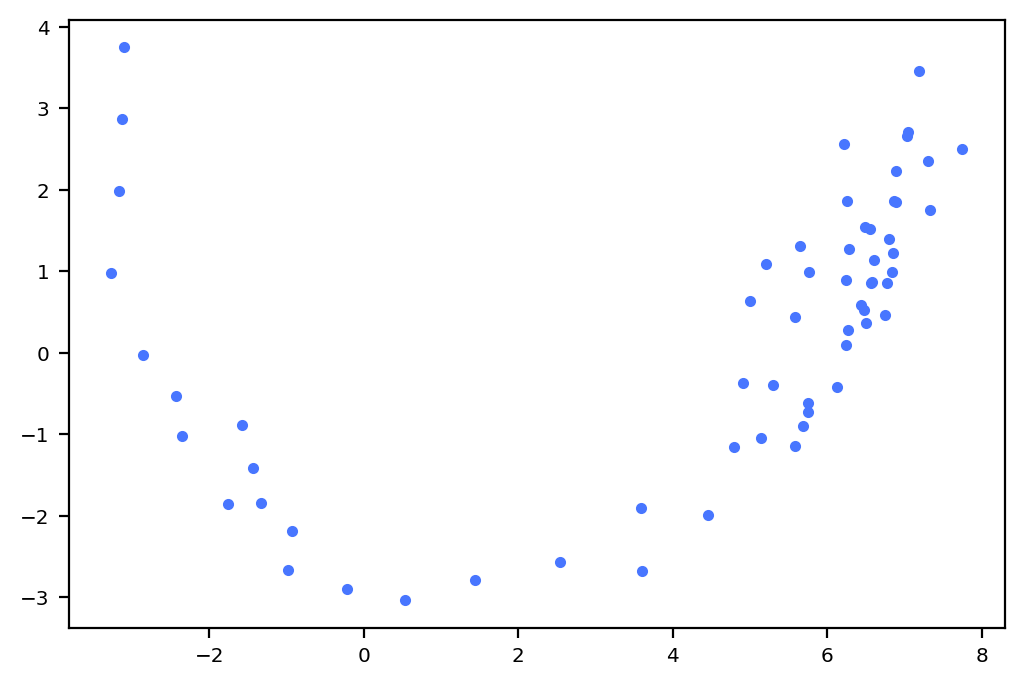

In [7]:
extend_range=1
x = np.arange(len(path0))
f = interp1d(x, path0,axis=0,fill_value='extrapolate')
xnew=np.arange(-extend_range,path0.shape[0]+extend_range)
extend_path0 = f(xnew)
plt.plot(extend_path0[:,0],extend_path0[:,1],'.')
plt.show()
np.save(result_path+'EG_rc_extend.npy',extend_path0 )

In [8]:
path0=np.load(result_path+'EG_dyn_rc.npy')
path0[:,0]=-path0[:,0]

/tmp/ipykernel_2892/1280999850.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm=plt.cm.get_cmap('jet')


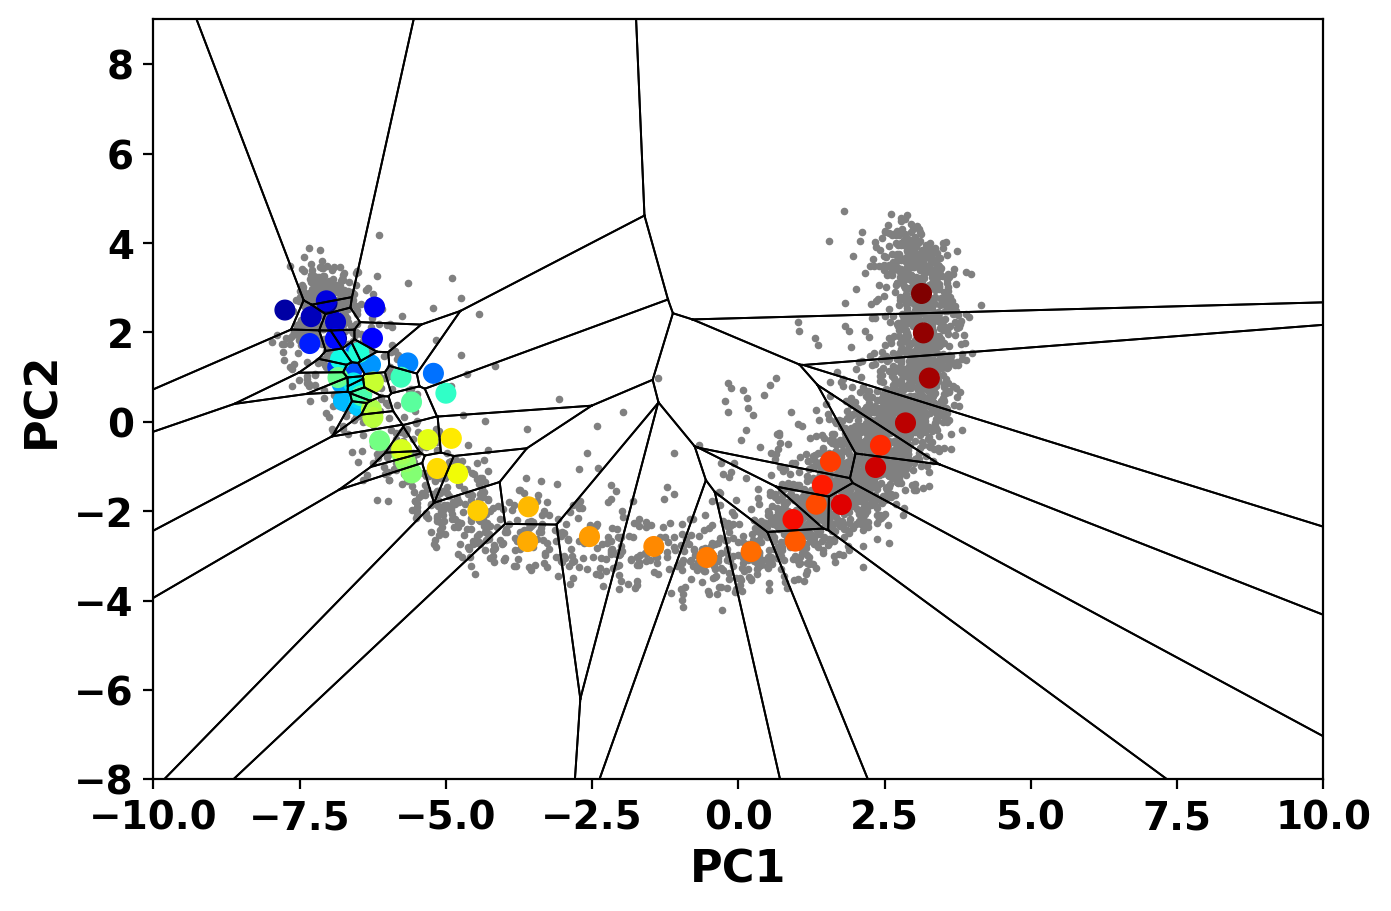

In [9]:
X0=traj_cl0


dot_color2=np.arange(path0.shape[0])
cm=plt.cm.get_cmap('jet')


fig,ax=plt.subplots(figsize=(7.5,5))


plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,color='grey')#,c=rho_w,cmap='viridis'


vor = Voronoi(path0[:,:2])
regions, vertices = voronoi_finite_polygons_2d(vor,radius=20)
for region in regions:
    polygon = vertices[region]
    for i in range(0,len(polygon)-1):
        plt.plot([polygon[i,0],polygon[i+1,0]], [polygon[i,1],polygon[i+1,1]], linewidth=0.7,color='k')
    plt.plot([polygon[-1,0],polygon[0,0]], [polygon[-1,1],polygon[0,1]],  linewidth=0.7,color='k')
    

# voronoi_plot_2d(vor,show_vertices=False,show_points=False)
plt.scatter(path0[:,0],path0[:,1],s=50,c=dot_color2,cmap=cm)

plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.axis([-10,10,-8,9])

plt.savefig(result_path+'EG_vor.png',dpi=300)
plt.show()

In [10]:
path0

array([[-7.03071142e+00,  2.65933244e+00, -2.64731638e+00,
         7.00312161e-01,  3.72353446e-01, -2.71648301e-02,
         8.76360220e-02, -1.49968581e-01, -2.05637700e-02,
         1.48502377e-01],
       [-6.86861446e+00,  1.86468075e+00, -1.67828530e+00,
         2.21526733e-01,  1.21227794e+00,  7.10558084e-01,
        -9.24299270e-01,  3.11273838e-01, -3.38513972e-01,
         7.91338787e-01],
       [-7.75031617e+00,  2.49962542e+00, -1.66121386e+00,
        -5.20043057e-02, -1.47448269e-01, -3.30367760e-01,
         7.55555346e-03, -5.10519846e-01,  2.69645317e-01,
        -9.97157419e-01],
       [-7.30163166e+00,  2.35249567e+00, -1.35804058e+00,
        -3.36651685e-01, -7.51779074e-01, -4.67979793e-01,
         5.88380370e-01,  1.07067362e-01,  5.09795920e-02,
        -1.88967495e-01],
       [-6.88495211e+00,  2.22921109e+00, -1.31649480e+00,
         1.20929490e-01, -2.90748084e-01, -4.55046782e-01,
         1.61777959e-01,  6.31072658e-01, -5.03126137e-01,
         6.

nan